In [1]:
!nvidia-smi

Sat Dec 19 05:21:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
from numpy import genfromtxt
from numpy import asarray
import math
import copy
import os
from PIL import Image 
import cv2

patch_size = 64 #input = 64x64
label_size = 128 #output = 128x128

#get RGGB bayer image
def bayer_reverse(img):    
    height,width,c = img.shape;
    tmp = np.zeros([height,width]);
    for i in range( height ):
        for j in range( width ):
            if i % 2 == 0 :
                if j % 2 == 0:
                    tmp[i][j] = img[i][j][0];#R
                else:
                    tmp[i][j] = img[i][j][1];#G
            else :
                if j % 2 == 0:
                    tmp[i][j] = img[i][j][1];#G
                else:
                    tmp[i][j] = img[i][j][2];#B

    return tmp;

#split image to prepare the train set
def split(img,name):
    height,width,c = img.shape;
    # print(img.shape)
    count = 0;
    for i in range(0,height,30):
        for j in range(0,width,30):
            if( i + label_size < height and j + label_size < width ):
                tmp = np.zeros([label_size,label_size,3]);
                tmp2 = np.zeros([label_size,label_size,3]);
                
                tmp = img[ i : i + label_size, j : j + label_size,:];
                
                #save splite label                
                path = 'drive/My Drive/Colab Notebooks/undergraduate_project/label/'+name.split('.')[0] +'_'+str(count)+'.png';
                #tmp = tmp/255
                im = Image.fromarray(tmp)
                #tmp2 = tmp
                # print(tmp2.shape)
                tmp2[:,:,0] = tmp[:,:,2]
                tmp2[:,:,1] = tmp[:,:,1]                
                tmp2[:,:,2] = tmp[:,:,0]
                #im.save(path)
                cv2.imwrite(path,tmp2)

                zoom = im.resize((patch_size,patch_size)) 
                zoom2 = np.zeros([patch_size,patch_size,3]);
                gray =  np.zeros([patch_size,patch_size]);
                
                zoom = np.array(zoom)
                zoom2[:,:,0] = zoom[:,:,2]
                zoom2[:,:,1] = zoom[:,:,1]                
                zoom2[:,:,2] = zoom[:,:,0]
                
                gray = bayer_reverse(zoom2)
                #gray = gray/255                
                path = 'drive/My Drive/Colab Notebooks/undergraduate_project/patch/'+name.split('.')[0] +'_'+str(count)+'.png';
                im = Image.fromarray(gray)
                #im = im.convert("L")
                #im.save(path)
                cv2.imwrite(path,gray)

                count = count + 1

def main():
        
    if not os.path.exists('drive/My Drive/Colab Notebooks/undergraduate_project/patch'):
        os.makedirs('drive/My Drive/Colab Notebooks/undergraduate_project/patch')
    
    if not os.path.exists('drive/My Drive/Colab Notebooks/undergraduate_project/label'):
        os.makedirs('drive/My Drive/Colab Notebooks/undergraduate_project/label')
    
    original_path = 'drive/My Drive/Colab Notebooks/undergraduate_project/koda'
    entries = os.listdir(original_path)
    for entry in entries:
        print(entry)
        path = original_path + '/' + entry
        img = Image.open(path)
        img = np.array(img)
        split(img,entry)



if __name__ == '__main__':
    main()
    

kodim01.png
kodim02.png
kodim03.png
kodim04.png
kodim05.png
kodim07.png
kodim06.png
kodim08.png
kodim09.png


In [7]:
import numpy as np
#from tensorflow.keras import layers
from keras.preprocessing import image
import tensorflow as tf 
from keras.models import Model,load_model
from keras.utils import to_categorical
import os
import keras
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Lambda
from keras.optimizers import Adam
from keras import backend as K
import random
from PIL import Image 
from random import shuffle

batch_sz = 16
oti = 'adam'
lr = 0.0002
e_num = 10


#http://ethen8181.github.io/machine-learning/keras/resnet_cam/resnet_cam.html
#https://ithelp.ithome.com.tw/articles/10223034


# def main():
  # train_image = np.load('train_image.npy')
  # train_label = np.load('train_label.npy')

  # test_image = np.load('test_img.npy')
  # test_label = np.load('test_lab.npy')


train_image = []
train_label = []

entries = os.listdir('drive/My Drive/Colab Notebooks/undergraduate_project/patch')
for entry in entries:
  im = image.load_img('drive/My Drive/Colab Notebooks/undergraduate_project/patch/'+entry, target_size = (64, 64))
  img = image.img_to_array(im)
  img = img[:,:,0]
  img = img[:,:,np.newaxis]
  train_image.append(img)
train_image= np.stack(train_image)

print(train_image.shape)# (x,128,128,1)
np.save('train_image',train_image)

entries = os.listdir('drive/My Drive/Colab Notebooks/undergraduate_project/label')
for entry in entries:
  im = image.load_img('drive/My Drive/Colab Notebooks/undergraduate_project/label/'+entry, target_size = (128, 128))
  img = image.img_to_array(im)
  train_label.append(img)
train_label = np.stack(train_label)

print(train_label.shape)# (x,256,256,3)

np.save('train_label',train_label)

index = [i for i in range(train_image.shape[0])]
shuffle(index)
train_image = train_image[index,:,:,:];
train_label = train_label[index,:,:,:];


inputs = keras.Input(shape=(None,None,1))

##Subpixel Construction
sub_layer_2 = Lambda(lambda x:tf.nn.space_to_depth(x,2)) 
init = sub_layer_2(inputs=inputs)



##Learning Residual (DCNN)
####Conv 3x3x64x64 + PReLu
x = keras.layers.Conv2D(filters = 64, #feature map number
                    kernel_size = 3, 
                    strides = 1,  # 2
                    padding = 'same', 
                    input_shape = (None,None,1))(init)

x = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)

####Residual Block
for i in range(6):
  Conv1 = keras.layers.Conv2D(filters = 64, #feature map number
                      kernel_size = 3, 
                      strides = 1,  # 2
                      padding = 'same',
                      input_shape = (None,None,64))(x)
  
  PReLu = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(Conv1)
  Conv2 = keras.layers.Conv2D(filters = 64, #feature map number
                      kernel_size = 3, 
                      strides = 1,  # 2
                      padding = 'same',
                      input_shape = (None,None,64))(PReLu)
  
  
  x = keras.layers.Add()([Conv2,x])
  x = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)
####Conv 3x3x64x64 + PReLu
x = keras.layers.Conv2D(filters = 64, #feature map number
                    kernel_size = 3, 
                    strides = 1,  # 2
                    padding = 'same', 
                    input_shape = (None,None,1))(x)

x = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)
####Conv 3x3x64x48
x = keras.layers.Conv2D(filters = 48, #feature map number
                    kernel_size = 3, 
                    strides = 1,  
                    padding = 'same',                      
                    input_shape = (None,None,64))(x)

###########Learning Residual (DCNN)############


##Recovery From Subpixel
sub_layer = Lambda(lambda x:tf.nn.depth_to_space(x,4)) 
Residual_Output = sub_layer(inputs=x)


##Initial Prediction
R = Lambda(lambda x: x[:,:,:,0])(init)
G = Lambda(lambda x: x[:,:,:,1:3])(init)
G = Lambda(lambda x: K.mean(x, axis=3))(G)
B = Lambda(lambda x: x[:,:,:,3])(init)
print(init.shape)
print(R.shape)
print(G.shape)
print(B.shape)
R = Lambda(lambda x: tf.expand_dims(x, -1))(R)
G = Lambda(lambda x: tf.expand_dims(x, -1))(G)
B = Lambda(lambda x: tf.expand_dims(x, -1))(B)

#rgb = tf.keras.backend.stack((R, G,B),axis =  3)
print(R.shape)
rg = keras.layers.Concatenate(axis = 3)([R , G])
rgb = keras.layers.Concatenate(axis = 3)([rg,B])
print(rgb.shape)
Coarse_Output = keras.layers.UpSampling2D(size=(4, 4))(rgb)


## + 
outputs = keras.layers.Add()([Residual_Output,Coarse_Output])
#outputs = Residual_Output

model = keras.Model(inputs=inputs, outputs=outputs, name="JDMSR_model")
model.summary()
#model.compile(optimizer=keras.optimizers.Nadam(lr), loss = 'mean_squared_error', metrics = ['mse'])
model.compile(optimizer=Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss = 'categorical_crossentropy', metrics = ['accuracy'])

#histories = Histories()
checkpoint = ModelCheckpoint('./model.hdf5',verbose=1, monitor='val_loss', 
                              save_best_only=True,save_weights_only=True)
rrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_lr=0.0000002)

history = model.fit(train_image, train_label, epochs=e_num, batch_size=batch_sz,verbose=1,
            validation_split = 0.1,callbacks=[checkpoint,rrp],shuffle = True)

# model.save("trashn.h5")
# loss, accuracy = model.evaluate(test_image,test_label)
# print(loss)


# if __name__ == '__main__':
#     main()


(6864, 64, 64, 1)
(6864, 128, 128, 3)
(None, None, None, 4)
(None, None, None)
(None, None, None)
(None, None, None)
(None, None, None, 1)
(None, None, None, 3)
(None, None, None, 3)


NameError: ignored

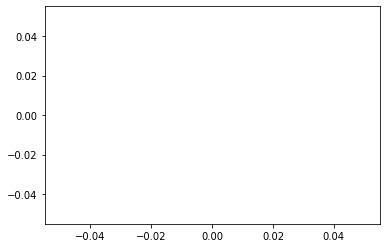

In [2]:
import matplotlib.pyplot as plt
# Plotting
fig = plt.figure()
plt.plot()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('model_accuracy.png')
plt.show()

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('model_loss.png')
plt.show()